In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
import numpy as np

In [ ]:
txt_file_path = './data/LynxHare.txt'
csv_file_path = './data/LynxHare.csv'

column_name = ['Year', 'Hare', 'Lynx']

try:
    data = pd.read_csv(
        txt_file_path,
        sep=r'\s+',
        header=None,
        names=column_name
    )

    data.to_csv(csv_file_path, index=False)
    print(f"Data successfully converted and saved to {csv_file_path}")
    
except FileNotFoundError:
    print(f"Error: The file {txt_file_path} was not found.")

Data successfully converted and saved to ./data/LynxHare.csv


In [2]:
csv_file_path = './data/LynxHare.csv'
df = pd.read_csv(csv_file_path)
df.head()

,Year,Hare,Lynx
0,1845,19.58,30.09
1,1846,19.60,45.15
2,1847,19.61,49.15
3,1848,11.99,39.52
4,1849,28.04,21.23


In [5]:
df.isnull().sum()

Year    0
Hare    0
Lynx    0
dtype: int64

In [6]:
print(df.shape)

(91, 3)


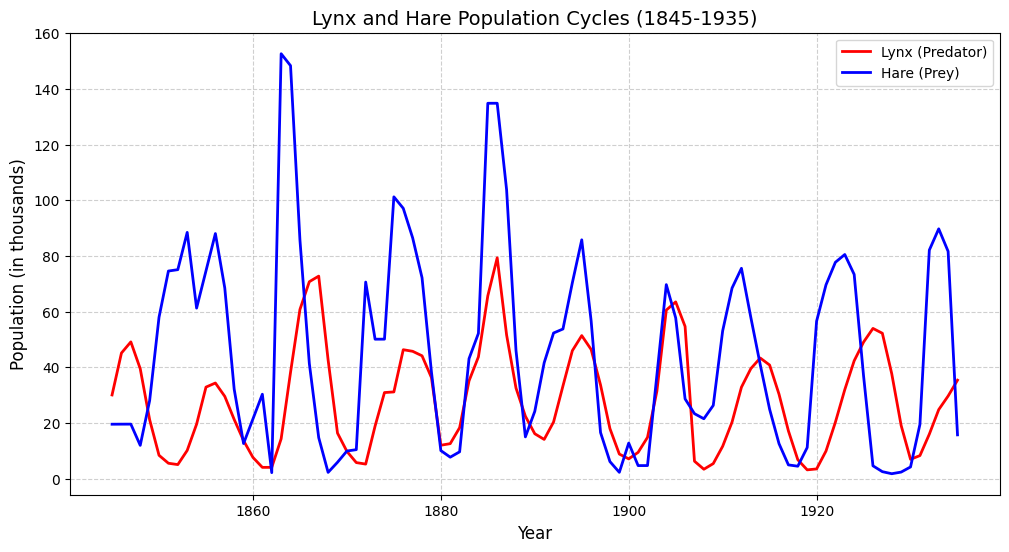

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df['Year'], df['Lynx'],
        label='Lynx (Predator)',
         color='red',
         linewidth=2)

ax.plot(df['Year'], df['Hare'],
        label='Hare (Prey)',
         color='blue',
         linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Population (in thousands)', fontsize=12)
ax.set_title('Lynx and Hare Population Cycles (1845-1935)', fontsize=14)

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()


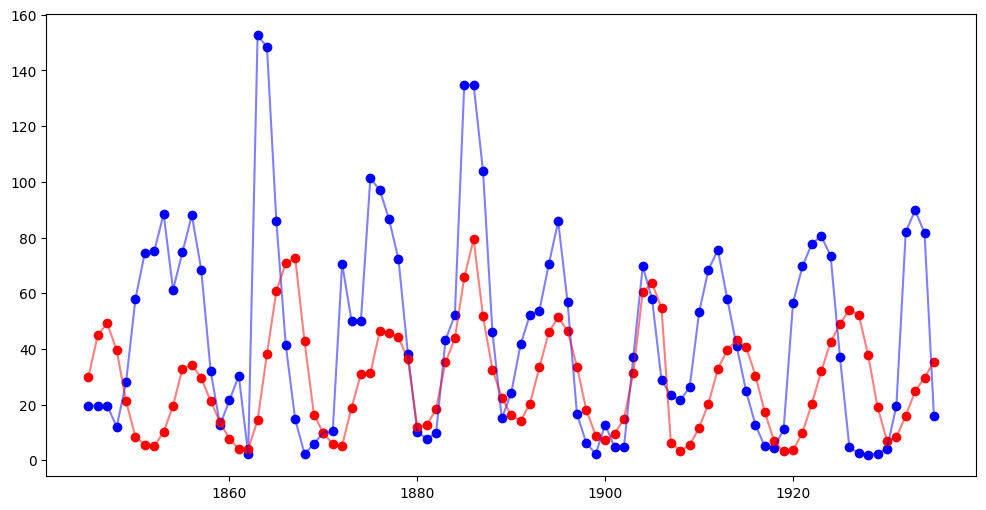

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data['Year'], data['Hare'], label='Hare (Line)', color='blue', alpha=0.5)
ax.plot(data['Year'], data['Lynx'], label='Lynx (Line)', color='red', alpha=0.5)

ax.scatter(data['Year'], data['Hare'], label='Hare (Points)', color='blue')
ax.scatter(data['Year'], data['Lynx'], label='Lynx (Points)', color='red')

In [ ]:
print(df.describe())

             Year        Hare       Lynx
count    91.00000   91.000000  91.000000
mean   1890.00000   45.406484  28.336593
std      26.41338   36.375402  18.864463
min    1845.00000    1.800000   3.190000
25%    1867.50000   12.730000  11.840000
50%    1890.00000   40.970000  29.590000
75%    1912.50000   71.405000  42.520000
max    1935.00000  152.650000  79.350000


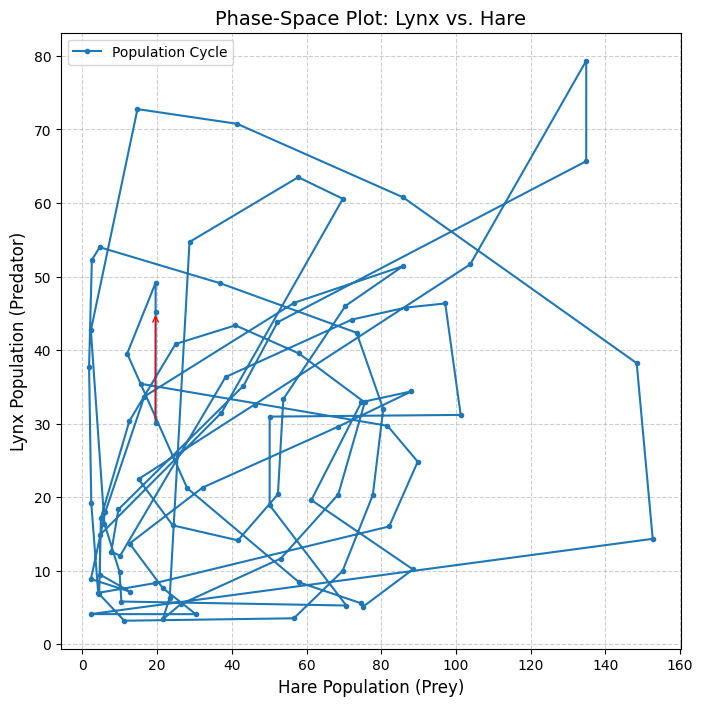

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))


ax.plot(data['Hare'], data['Lynx'], 
            label='Population Cycle',
            marker='o',       
            markersize=3,        
            linestyle='-')

ax.set_xlabel('Hare Population (Prey)', fontsize=12)
ax.set_ylabel('Lynx Population (Predator)', fontsize=12)
ax.set_title('Phase-Space Plot: Lynx vs. Hare', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

ax.annotate("",
            xy=(data['Hare'][1], data['Lynx'][1]),
            xytext=(data['Hare'][0], data['Lynx'][0]),
            arrowprops=dict(arrowstyle="->", color="red"))

plt.show()

In [3]:
def lotka_volterra(t, y, alpha, beta, delta, gamma):
    x= y[0]
    y=y[1]

    dxdt = (alpha * x) - (beta * x * y)
    dydt = (delta * x * y) - (gamma * y)

    return [dxdt, dydt] 

In [4]:
t_points = df['Year'].values
Hare = df['Hare'].values
Lynx = df['Lynx'].values

data = np.array([Hare, Lynx])

y0 = [Hare[0], Lynx[0]]

def calculate_residuals(params, t, data, y0_init):
    alpha, beta, delta, gamma = params

    sol = solve_ivp(
        lotka_volterra,             
        (t.min(), t.max()),         
        y0_init,                    
        args=(alpha, beta, delta, gamma), 
        t_eval=t
    )

    if not sol.success:
        return np.full(data.size, 1e9)
    
    simulated_populations = sol.y

    error = data - simulated_populations

    return error.flatten()

In [5]:
initial_guess = [1.1, 0.4, 0.1, 0.4]

fit_result = least_squares(
    calculate_residuals,
    initial_guess,
    args=(t_points, data, y0),
    bounds=(0, np.inf)
)

if fit_result.success:
    best_fit_params = fit_result.x
    print("alpha:", best_fit_params[0])
    print("beta:", best_fit_params[1])
    print("delta:", best_fit_params[2])
    print("gamma:", best_fit_params[3])
else:
    print("optimization failed")

alpha: 1.1972432316279809
beta: 0.20237562019893165
delta: 0.09136850799445048
gamma: 0.37680589781329293


In [6]:
solve_best_fit = solve_ivp(
    lotka_volterra,
    (t_points.min(), t_points.max()),
    y0,
    args=tuple(best_fit_params),
    t_eval=t_points
)

simulated_hare = solve_best_fit.y[0]
simulated_lynx = solve_best_fit.y[1]

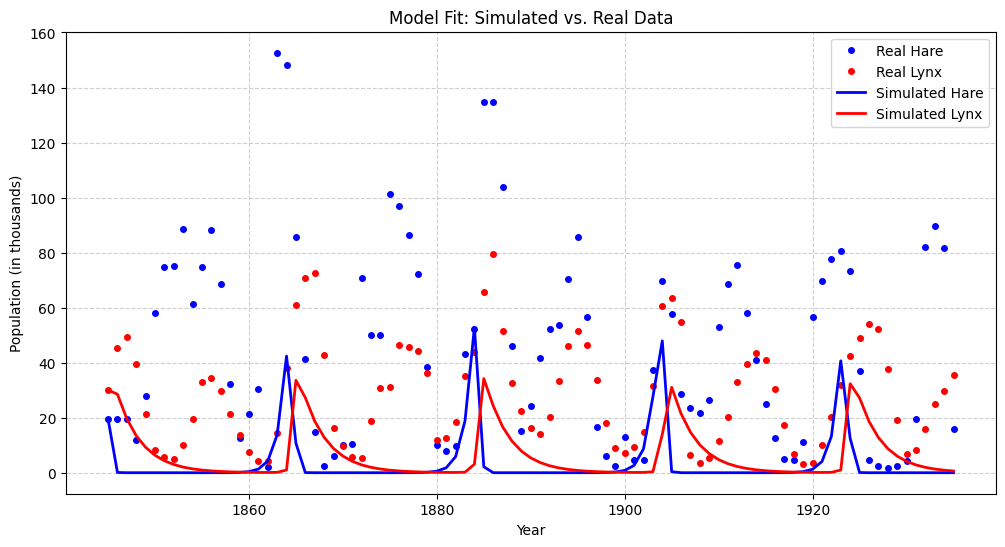

In [22]:
plt.figure(figsize=(12, 6))

plt.plot(t_points, Hare, 'bo', label='Real Hare', markersize=4)
plt.plot(t_points, Lynx, 'ro', label='Real Lynx', markersize=4)

plt.plot(t_points, simulated_hare, 'b-', label='Simulated Hare', linewidth=2)
plt.plot(t_points, simulated_lynx, 'r-', label='Simulated Lynx', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Population (in thousands)')
plt.title('Model Fit: Simulated vs. Real Data')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

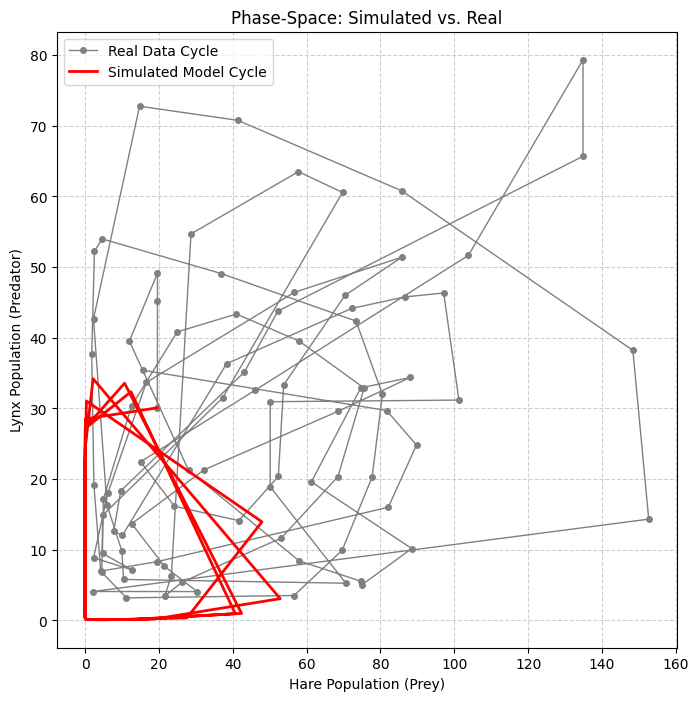

In [23]:
plt.figure(figsize=(8, 8))

# Plot the REAL data loop
plt.plot(Hare, Lynx, 'o-', 
         label='Real Data Cycle', color='gray', 
         markersize=4, linewidth=1)

# Plot the SIMULATED data loop
plt.plot(simulated_hare, simulated_lynx, 'r-', 
         label='Simulated Model Cycle', linewidth=2)

plt.xlabel('Hare Population (Prey)')
plt.ylabel('Lynx Population (Predator)')
plt.title('Phase-Space: Simulated vs. Real')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [7]:
cost = fit_result.cost
print(f"Cost: {cost:.2f}")

residuals = fit_result.fun
print(f"Total number of error values: {len(residuals)}")
print(f"Average Error (Mean Residual): {np.mean(residuals):.2f}")
print(f"Median Error (Median Residual): {np.median(residuals):.2f}")
print(f"Largest Single Error (Max Residual): {np.max(np.abs(residuals)):.2f} (in thousands of pelts)")
print(f"This means at least one data point was {np.max(np.abs(residuals)):.2f}k units off from the simulation.")
print("\n")

Cost: 167321.40
Total number of error values: 182
Average Error (Mean Residual): 31.79
Median Error (Median Residual): 25.51
Largest Single Error (Max Residual): 138.91 (in thousands of pelts)
This means at least one data point was 138.91k units off from the simulation.




In [8]:
epsilon = 1e-6 

mape_hare = np.mean(
    np.abs( (Hare - simulated_hare) / (Hare + epsilon) )
) * 100

mape_lynx = np.mean(
    np.abs( (Lynx - simulated_lynx) / (Lynx + epsilon) )
) * 100

print(f"--- Model 'Percentage Error' (MAPE) ---")
print(f"Mean Absolute Percentage Error (Hare):   {mape_hare:.2f} %")
print(f"Mean Absolute Percentage Error (Lynx):   {mape_lynx:.2f} %")

--- Model 'Percentage Error' (MAPE) ---
Mean Absolute Percentage Error (Hare):   91.94 %
Mean Absolute Percentage Error (Lynx):   80.80 %
